# Data download and exploratory analysis

Currently precipitation radar nowcasting is mainly done by optical flow or radial velocity estimates. If we use neural nets we can maybe capture the behavior of rain clouds better (e.g. a single summer evening cumulonimbus versus a heat front), and the topographic influences (e.g. fohn effect), without explicitly specifying rules or terrain.

## Relevant papers

It's already being done here: http://arxiv.org/pdf/1506.04214.pdf

## Data

The KNMI has an [open data program](http://data.knmi.nl) now. I identified three interesting datasets:

- [2008-] [5-min radar reflectivity composites](http://data.knmi.nl/datasets/radar_tar_refl_composites/1.0), this is what we're trying to establish the behavior of, and what should be our internal state.
- [2008-] [Forecasted 5-min radar reflectivity composites](http://data.knmi.nl/datasets/radar_forecast/1.0), this is our baseline, where they extrapolate the radar images based on a velocity estimate. Only the data of last day is online, which is a pity. Might contact them to get my hands on more data.
- [2008-] [5-min gauge-adjusted precipitation accumulations (1 km, extended mask)](http://data.knmi.nl/datasets/rad_nl25_rac_mfbs_em_5min/2.0), this can serve as the ground truth. Would be amazing if we can train with radar reflectivity as input and this as output, then the errors in the reflectivity composites might be diminished.
- [2014-] [Radar echo top height composites](http://data.knmi.nl/datasets/radar_tar_echotopheight_5min/1.0), I'm not keen on training on the full radar reflectivity volumes, but this might just be a nice derivative that does give extra information that might add to the model's predictive power.

Most of this data is available via FTP. The format, projection and extent is described at http://adaguc.knmi.nl/contents/datasets/productdescriptions/W_ADAGUC_Product_description_RADNL_OPER_R___25PCPRR_L3.html.

## Dependencies

`conda install h5py tqdm matplotlib pyproj`

`conda install -c conda-forge cartopy`

Use SIMD-accelerated pillow for faster resizing:
`CC="cc -mavx2" pip install -U --force-reinstall pillow-simd`

In [1]:
# All imports
import os, io, re, glob, tarfile, itertools
import concurrent.futures
from pprint import pprint

# Third parties
import h5py
import numpy as np
from IPython.display import Image
from ftplib import FTP
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

# Own code
import utils
import dataset

# Constants
folder = utils.RADAR_REFL_COMP_DIR

%matplotlib inline
%load_ext autoreload
%aimport utils
%aimport dataset
%autoreload 1

## File discovery radar reflectivity composites

The radar reflectivity composites are organized in *.tar* files, one per day. Let's retrieve all their filenames. (This can take a while for something like 10\*365 filenames.)

In [104]:
## Ok, now on to the real stuff: radar reflectivity composites
refl_comp_ftp_urls = []

with FTP('data.knmi.nl', timeout=10) as ftp:
    print(ftp.login())
    yearfolders = ftp.nlst('/download/radar_tar_refl_composites/1.0/0001/')
    for yearfolder in yearfolders:
        for monthfolder in ftp.nlst(yearfolder):
            for dayfolder in ftp.nlst(monthfolder):
                # Should contain just one file
                for day_file in ftp.nlst(dayfolder):
                    refl_comp_ftp_urls.append(day_file)
                    # Use carriage return to overwrite
                    print("Retrieve filename # {}".format(len(refl_comp_ftp_urls)), end='\r')

print("Finished")

# Save to file for later retrieval
with open('refl_comp_ftp_urls.txt', 'w') as f:
    f.write('\n'.join(refl_comp_ftp_urls))

230 login accepted
Finished filename # 3607


Run the cell below to restore urls from file.

In [2]:
# Run this to restore from file
with open('refl_comp_ftp_urls.txt', 'r') as f:
    # Clean up \n's
    refl_comp_ftp_urls = [l.strip() for l in f.readlines()]
print("Loaded {} filenames".format(len(refl_comp_ftp_urls)))

Loaded 3607 filenames


## Downloading radar reflectivity composite *.tar*s

Now we download all files. You probably want to download a smaller subset at first because this can take hours (it's >75GB and their ftp server is not so fast).

In [105]:
with FTP('data.knmi.nl', timeout=10) as ftp:
    print(ftp.login())
    for ftp_url in tqdm_notebook(refl_comp_ftp_urls, desc="Downloading files", unit="file"):
        utils.download_cache_ftp(utils.RADAR_REFL_COMP_DIR, ftp, ftp_url, verbose=False)

230 login accepted


HBox(children=(IntProgress(value=0, description='Downloading files', max=10), HTML(value='')))

Next step is to untar all the files. I'd like to do that in streaming fashion but the h5py library doesn't support that in an easy way.

So now we untar to disk, taking care to check if the files exist and then deleting the original file to save space. The code is slightly more verbose because of the concurrency.

In [4]:
tar_files = sorted(glob.glob(os.path.join(folder, '*.tar')))

print("Found {} tar files in {}".format(len(tar_files), folder))

utils.untar_concurrent(tar_files)

Found 0 tar files in /home/ubuntu/nowcasting-convrnn/data/radar_refl_comp
Submitted all tasks


HBox(children=(IntProgress(value=1, bar_style='info', description='Extracting', max=1), HTML(value='')))

## File discovery and download of forecasted reflectivities

Unfortunately only forecasted reflectivities (5-min intervals, 2h ahead) for the last 24h are available.

In [7]:
with FTP('data.knmi.nl', timeout=10) as ftp:
    print(ftp.login())
    # Only data of last 24 hours is stored here
    most_recent_year = sorted(ftp.nlst('/download/radar_forecast/1.0/noversion/'))[-1]
    most_recent_month = sorted(ftp.nlst(most_recent_year))[-1]
    # These 24 hours are usually divided over 2 days except when the clock strikes midnight
    days = sorted(ftp.nlst(most_recent_month))
    predictions = []
    for day in days:
        # Use extend cause ftp.nlst returns array of arrays
        predictions.extend(ftp.nlst(day))
    predictions.sort()
    # Split limited number of times to show the year/month/day folders
    print("Found {} predictions from {} to {}".format(
        len(predictions),
        predictions[0].split('/',5)[-1],
        predictions[-1].split('/',5)[-1]))

    # Download last day of predictions
    for ftp_url in tqdm_notebook(predictions, desc="Downloading files", unit="file"):
        # Give file unique name by including year/month/day (only time is in forecast filename)
        filename = ftp_url.split('/',5)[-1].replace('/','-')
        utils.download_cache_ftp(utils.RADAR_FORECAST_REFL_COMP_DIR, ftp, ftp_url, filename=filename)

230 login accepted
Found 294 predictions from 2017/11/28/RAD_NL25_PCP_FM_1200.h5 to 2017/11/29/RAD_NL25_PCP_FM_1225.h5


HBox(children=(IntProgress(value=0, description='Downloading files', max=294), HTML(value='')))

## Explore dataset

There is a nice abstraction in `dataset.ReflCompDataset`, which makes it easier to load and work with data. Let's load a bunch and check out the structure of the hdf5 file.

In [2]:
ds = dataset.ReflCompDataset(utils.RADAR_REFL_COMP_DIR)
print("File 20 contains:")
print(ds.show_structure(-1))

File 20 contains:
geographic
	<HDF5 group "/geographic" (1 members)>
		geo_par_pixel: b'X,Y'
		geo_dim_pixel: b'KM,KM'
		geo_pixel_def: b'LU'
		geo_number_columns: [700]
		geo_number_rows: [765]
		geo_pixel_size_x: [ 1.00000346]
		geo_pixel_size_y: [-1.00000477]
		geo_column_offset: [ 0.]
		geo_row_offset: [ 3649.98193359]
		geo_product_corners: [  0.          49.36206436   0.          55.97360229  10.85645294
  55.38897324   9.00930023  48.89530182]
geographic/map_projection
	<HDF5 group "/geographic/map_projection" (0 members)>
		projection_indication: b'Y'
		projection_name: b'STEREOGRAPHIC'
		projection_proj4_params: b'+proj=stere +lat_0=90 +lon_0=0 +lat_ts=60 +a=6378.14 +b=6356.75 +x_0=0 y_0=0'
image1
	<HDF5 group "/image1" (3 members)>
		image_product_name: b'RAD_NL25_PCP_H1.5_NA'
		image_geo_parameter: b'REFLECTIVITY_[DBZ]'
		image_size: [535500]
		image_bytes_per_pixel: [1]
image1/calibration
	<HDF5 group "/image1/calibration" (0 members)>
		calibration_flag: b'Y'
		calibration

Let's calculate the mean of a bunch of files in the dataset.

In [ ]:
def sum_array(indexes):
    firsttime = True
    accumulator = None
    # Prevent too many open file errors
    for indx in indexes:
        with h5py.File(ds.h5files[indx], 'r') as f:
            try:
                img = np.array(f['image1']['image_data']).astype(np.float32)
            except KeyError:
                # Ignore when it doesn't have 'image1'
                # TODO: Signal
                return accumulator
            # Set out of range to 0
            img[img==255] = 0
            # Cutoff at 60
            img[img<60] = 0
            if firsttime:
                firsttime = False
                accumulator = img
            else:
                accumulator += img
    return accumulator

def reduce_func(iterator, l):
    # Mean
    return np.sum(iterator, axis=0) / l

longterm_mean = utils.map_reduce_concurrent(range(800000), sum_array, reduce_func,
                             n_workers=16, chunk_size=1000)


Now let's plot this longterm mean.

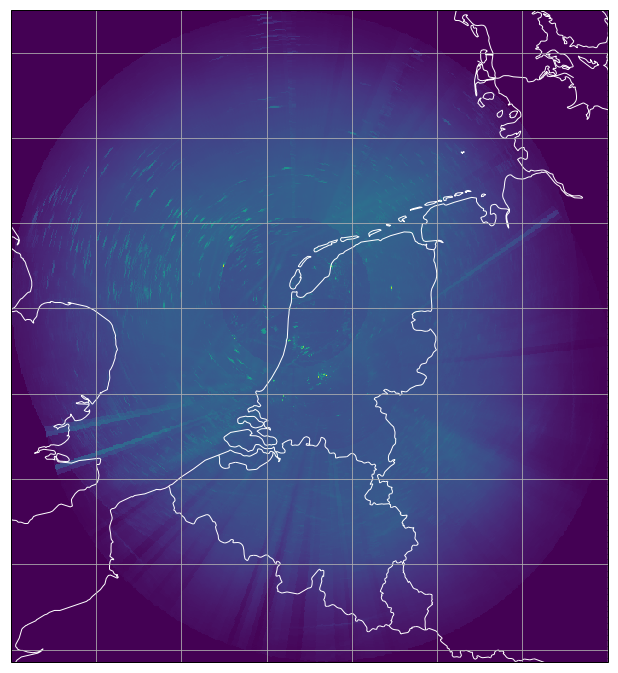

In [51]:
#[250:550,200:500]
img_data = ds[0]['image1/image_data']
img_data[img_data==255] = 0
utils.plotting.plot_radar(ds[0], longterm_mean)

We can see that there are some patterns caused by the radar scanning in elevation intervals and some interference further away probably caused by obstacles. The radar angle is quite low when looking far away.

Now let's find out where they cut off the forecasted images to reduce clutter.

In [3]:
predh5s = sorted(glob.glob(os.path.join(utils.RADAR_FORECAST_REFL_COMP_DIR, '*.h5')))

img_data = []

def get_img_data(name, obj):
    m = re.match('^image(\d+)/image_data', name)
    if m:
        i = int(m.groups()[0])
        img_data.append([i, np.array(obj)])

with h5py.File(predh5s[0], 'r') as f:
    f.visititems(get_img_data)

# They might have been visited in arbitrary order
img_data = [d for i,d in sorted(img_data, key=lambda o: o[0])]

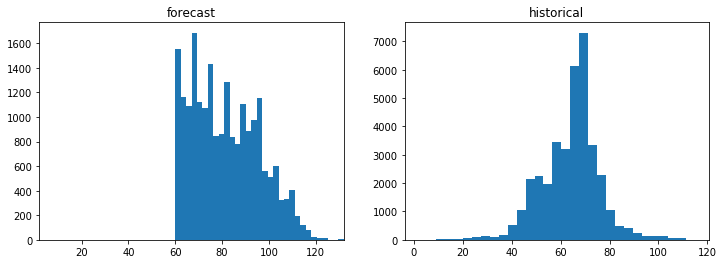

In [36]:
plt.figure(figsize=(12,4))
ax1 = plt.subplot(121)
ax1.set_title('forecast')
# 60 cutoff
a = img_data[0][img_data[0]>0].ravel()
plt.hist(a, bins=255//8)

ax2 = plt.subplot(122)
ax2.set_title('historical')
b = np.array(ds[0]['image1/image_data'])
b = b[(b>0)&(b<255)].flatten()
plt.hist(b, bins=255//8)
ab = np.concatenate((a,b))

ax1.set_xlim((ab.min(), ab.max()));

So obviously they cut them off at a pixel value of 60.

## Calculating precipitation metrics

To train the model and compare it we need precipitation metrics, which we will take from [here](https://arxiv.org/pdf/1506.04214.pdf).

The commonly used precipitation metrics are:
 - Rainfall-MSE *average squared error between the predicted rainfall and the ground truth (needs conversion of pixel values -> radar intensity [dB] -> rainfall (Z-R relationship)*

For the following metrics the prediction and ground truth is converted to a 0/1 matrix using a treshold of $0.5mm/h$.
 - Critical Success Index (CSI) $\frac{hits}{hits+misses+falsealarms}$
 - False Alarm Rate (FAR) $\frac{falsealarms}{hits+falsealarms}$
 - Probability Of Detection (POD) $\frac{hits}{hits+misses}$


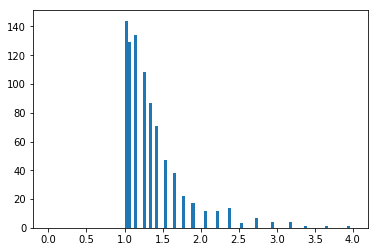

In [46]:
def pixelval_to_mmh(arr):
    """
    Convert 
    http://adaguc.knmi.nl/contents/datasets/productdescriptions/W_ADAGUC_Product_description_RADNL_OPER_R___25PCPRR_L3.html
    """
    r = 10 ** ((arr - 109) / 32)
    return r

d = img_data[0]
d[d==255] = 0
plt.hist(pixelval_to_mmh(d).ravel(), range=(0,4), bins=100);